In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm
#import dask.dataframe as dd

C:\Users\liamc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#read in members and train datafiles
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
train = pd.read_csv(r'E:\KKbox\train_v2.csv')
#create training dataframe 
train = train.merge(members,how='left',on=['msno'])

In [3]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = train['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [4]:
#select only logs for the last two months before the churn window, which for the train set is March 2017
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-03-01') & (relevant_user_logs['date']>'2016-12-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [5]:
#aggregate the logs by mean so you can have one row of log info per user
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [6]:
#merge the mean log data into the dataframe
mean_user_logs = mean_user_logs.reset_index()
train = train.merge(mean_user_logs,how='left',on='msno')

In [7]:
#read in transactions data, manipulate it to create feature for number of transactions, then clear memory and add data of the 
#most recent transaction to the training dataframe
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
train = pd.merge(train, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
train = pd.merge(train, transactions, how='left', on='msno')
transactions=[]

In [8]:
train= train.fillna(0)

In [9]:
#replace columns that have categorical data with dummy variables
train = pd.get_dummies(train,columns=['city','registered_via','gender'])

In [10]:
#check how many churners are in the dataframe relative to the size of the dataframe
print(train.is_churn.sum())
print(train.shape)

87330
(970960, 52)


In [11]:
train.msno.nunique()

970960

In [12]:
#can optionally subset the dataframe into churners and nonchurners and reconstruct with a higher ratio of churners in order to 
#produce a better trained model
churners= train.loc[train['is_churn']==1]
nonchurners= train.loc[train['is_churn']==0]
nonchurners= nonchurners.sample(n=107000)
morechurnersdf = pd.concat([churners,nonchurners])

In [13]:
#identify features and target variable for calculating VIF
y = train['is_churn']
X = train.drop(['is_churn','msno',],axis=1)

In [14]:
#display vif of all features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

C:\Users\liamc\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.208460e+00,bd
1,1.063400e+05,registration_init_time
2,2.258659e+00,num_25
3,inf,num_50
4,3.028624e+00,num_75
5,inf,num_985
6,4.051291e+01,num_100
7,6.659412e+00,num_unq
8,4.869610e+01,total_secs
9,1.874441e+00,days_logged


In [15]:
#select features and target variable for model.  Can change to eliminate high VIF features
y = train['is_churn']
X = train.drop(['is_churn','msno',],axis=1)
#X = train.drop(['is_churn','msno','num_100','total_secs'],axis=1)
#X = train.drop(['is_churn','msno','total_secs'],axis=1)
#X= train[['bd','num_25','num_75','num_100','num_unq','days_logged','days_since_registered']]

In [16]:
#split into train and test sets and initialize classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=21)

In [32]:
#train
logreg = LogisticRegression(C=0.439,penalty='l1')
logreg.fit(X_train,y_train)

LogisticRegression(C=0.439, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
#make predictions on test set
y_pred = logreg.predict(X_test)

In [34]:
#check confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[174087   2627]
 [  4606  12872]]
             precision    recall  f1-score   support

          0       0.97      0.99      0.98    176714
          1       0.83      0.74      0.78     17478

avg / total       0.96      0.96      0.96    194192



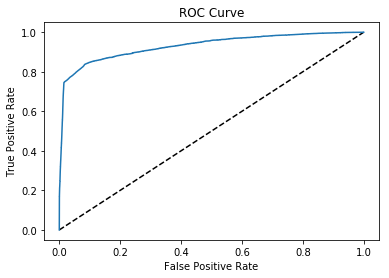

AUC: 0.930369867332425
AUC scores computed using 5-fold cross-validation: [0.93050172 0.93161247 0.93247322 0.93317596 0.93165063]


In [35]:
#Check ROC curve, AUC score, and 5 fold cv AUC
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

In [23]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss',cv=5)
logreg_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'penalty': 'l1'}
Best score is -0.13339213827910448


In [36]:
#check log loss
log_loss(y_test,y_pred_prob)

0.13416865382929385

In [38]:
#model coefficients
Coefficients = pd.DataFrame()
Coefficients['features'] = X.columns
Coefficients['model_coefficients'] = np.transpose(logreg.coef_)
Coefficients

,features,model_coefficients
0,bd,1.967041e-03
1,registration_init_time,1.144987e-09
2,num_25,-2.771287e-03
3,num_50,-1.389928e-01
4,num_75,-2.567922e-02
5,num_985,1.409993e-01
6,num_100,6.785738e-05
7,num_unq,-8.526211e-04
8,total_secs,7.253196e-07
9,days_logged,-4.021276e-02


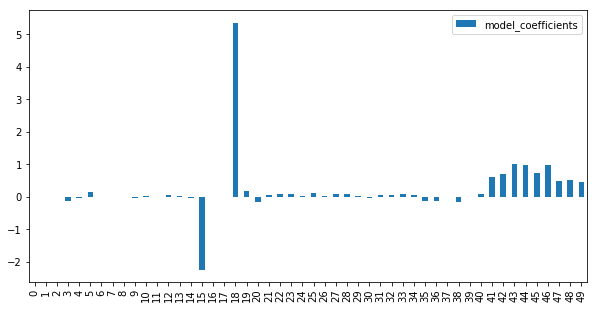

In [45]:
Coefficients.plot(kind='bar',figsize=(10,5))

In [57]:
train = []
sample_submission = pd.read_csv(r'E:\KKbox\sample_submission_v2.csv')
test = sample_submission.merge(members,how='left',on=['msno'])

In [58]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = test['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [59]:
#The provided test set are for users churning in the next month after the train set
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-04-01') & (relevant_user_logs['date']>'2017-01-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [60]:
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [61]:
mean_user_logs = mean_user_logs.reset_index()
test = test.merge(mean_user_logs,how='left',on='msno')

In [62]:
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
test = pd.merge(test, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

In [63]:
test= test.fillna(0)

In [64]:
test = pd.get_dummies(test,columns=['city','registered_via','gender'])
print(test.is_churn.sum())
print(test.shape)

0
(907471, 52)


In [65]:
Xsubmission = test.drop(['is_churn','msno'],axis=1)
ysubmissionprob =logreg.predict_proba(Xsubmission)[:,1]

In [66]:
sample_submission['is_churn'] = ysubmissionprob

In [67]:
sample_submission

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.017461
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.006026
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.013069
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.015370
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.015650
5,nu1jZ/flvSaXRg0U9Es+xmo2KlAXq/q+mhcWFStwm9w=,0.046710
6,biDTtgK83fEWXJDaxzD1eh22dion/h3odeIbS7qJMmY=,0.012557
7,k/8uwi/iM9LZmRAIWXLqpZY6ENomXAscwsQsh6PxcTw=,0.013626
8,18rQ/746SjA6nBx325UsyhfsDhu4tK01FXFxHWZjw20=,0.006638
9,2V13OCoWx6vqKr/ZzNmKFrmnC2FtR4SWMz5C5Hi02PY=,0.018417


In [68]:
sample_submission.to_csv('submission.csv', index=False)